In [1]:
 !pip install transformers

In [2]:
import tensorflow as tf
import logging
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv1D,
    Dropout,
    Input,
    LSTM,
    Bidirectional
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from transformers import BertTokenizer, TFBertModel
from sklearn.linear_model import LogisticRegression
import os
import pandas as pd
import numpy as np
import keras
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()
import re
import random
import torch

In [3]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/6-class-bert-preprocessed-dataset/Bert_Preprocessed_Dataset.xlsx


In [5]:
max_length = 100
batch_size = 32
test_size = 0.1
num_class = 6

In [6]:
model_name = "sagorsarker/bangla-bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [7]:
df=pd.read_excel('/kaggle/input/6-class-bert-preprocessed-dataset/Bert_Preprocessed_Dataset.xlsx')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405 entries, 0 to 6404
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6405 non-null   int64 
 1   ID          6404 non-null   object
 2   Text        6404 non-null   object
 3   Sentiment   6405 non-null   object
 4   Label       6405 non-null   int64 
 5   Token       6405 non-null   object
 6   Token_ID    6405 non-null   object
dtypes: int64(2), object(5)
memory usage: 350.4+ KB


In [8]:
df.head()

,Unnamed: 0,ID,Text,Sentiment,Label,Token,Token_ID
0,479,939195189512152_939206382844366,উনারে লাথথায়ে মিরপুর চিড়িয়াখানার প্রধান সিকিউর...,angry,0,"['উনার', '##ে', 'লা', '##থ', '##থা', '##যে', '...","[36081, 2094, 3853, 7740, 12969, 8844, 15638, ..."
1,1750,935156429916028_935165096581828,কই এখন আপনি লেকচার থেমে গেল কেন ভাই,angry,0,"['কই', 'এখন', 'আপনি', 'লেকচার', 'থেমে', 'গেল',...","[6852, 2112, 2536, 22174, 3214, 2590, 2304, 2570]"
2,1855,987743164678331_1529633654011820,সুন্দর জোক্স,happy,3,"['সনদ', '##র', 'জে', '##াক', '##স']","[5391, 2046, 4803, 15547, 2388]"
3,1382,935324716565866_935576566540681,বেশির ভাগ ক্ষেত্রে যাত্রী গন কম ভুল করে আর বেশ...,sad,4,"['বেশির', 'ভাগ', 'কষে', '##তর', '##ে', 'যা', '...","[3217, 2516, 19675, 12499, 2094, 2120, 42396, ..."
4,3388,987743164678331_552808888211836,বাংলাদেশের হিন্দু মুসলিম সবাই ভাই ভাই যে অন্যন...,sad,4,"['বাংলাদেশের', 'হিন', '##দ', 'মস', '##লিম', 'স...","[2119, 50082, 5718, 23143, 33783, 2553, 2570, ..."


In [9]:
#df=df.drop_duplicates(subset=['Text'],inplace=True)

In [10]:
from sklearn.utils import shuffle
df = shuffle(df)

In [11]:
train=df[:int(.8*len(df))]
test=df[int(.8*len(df)):int(.9*len(df))]
validation=df[int(.9*len(df)):]
x_train=train['Text']
y_train=train['Label']
x_validation=validation['Text']
y_validation=validation['Label']
x_test=test['Text']
y_test=test['Label']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Text'],df['Label'] , test_size=0.1)
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.1)

In [12]:
x_train = x_train.astype(str)
#y_train = y_train.astype(str)
x_validation = x_validation.astype(str)
x_test = x_test.astype(str)
#y_test = y_test.astype(str)

In [13]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(
        data, max_length=max_length, padding="max_length", truncation=True
    )
    return tf.constant(tokens["input_ids"])
train_encoded = bert_encode(x_train)
validation_encoded=bert_encode(x_validation)
test_encoded = bert_encode(x_test)

train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_encoded, y_train))
    .shuffle(100)
    .batch(batch_size)
).cache()
validation_dataset = (
    tf.data.Dataset.from_tensor_slices((validation_encoded,y_validation))
    .shuffle(100)
    .batch(batch_size)
).cache()

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_encoded,y_test))
    .shuffle(100)
    .batch(batch_size)
).cache()


2022-04-19 06:22:39.446520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 06:22:39.447759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 06:22:39.448728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 06:22:39.451258: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
from keras.utils.vis_utils import plot_model

In [15]:
def bert_bangla_sentiment_model():
    bert_encoder = TFBertModel.from_pretrained(model_name, output_attentions=True)
    input_word_ids = Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    last_hidden_states = bert_encoder(input_word_ids)[0]
    #clf_output = Flatten()(last_hidden_states)
    net= Conv1D(200, kernel_size=3, activation = "relu")(last_hidden_states)
    net = Bidirectional(LSTM(128, return_sequences=True))(net)
    net = Flatten()(net)
    output = Dense(6, activation="softmax")(net)
    model = Model(inputs=input_word_ids, outputs=output)
    return model

In [16]:

    model = bert_bangla_sentiment_model()
    adam_optimizer = Adam(learning_rate=1e-5)
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"]
    )
    model.summary()

Downloading:   0%|          | 0.00/930M [00:00<?, ?B/s]

Some layers from the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at sagorsarker/bangla-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 164396544 
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 200)           461000    
_________________________________________________________________
bidirectional (Bidirectional (None, 98, 256)           336896    
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 150534    
Total params: 165,344,974
Trainable params: 165,344,974
Non-trainable params: 0
_______________________________________________

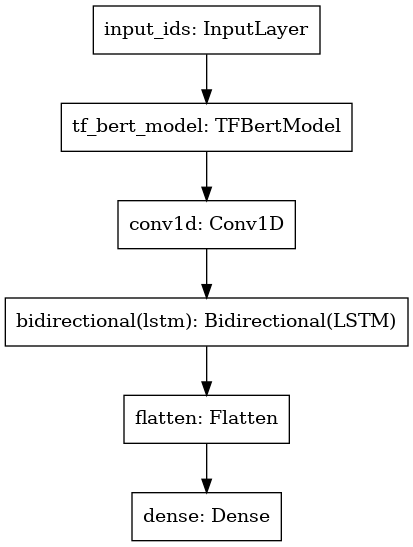

In [17]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [18]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=30,
    validation_data=validation_dataset,
    verbose=1,
)

Epoch 1/30


2022-04-19 06:23:31.423410: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-19 06:23:35.436147: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


161/161 [==============================] - 92s 439ms/step - loss: 1.6257 - accuracy: 0.3333 - val_loss: 1.5133 - val_accuracy: 0.4025
Epoch 2/30
161/161 [==============================] - 67s 418ms/step - loss: 1.4417 - accuracy: 0.4448 - val_loss: 1.3871 - val_accuracy: 0.4774
Epoch 3/30
161/161 [==============================] - 67s 418ms/step - loss: 1.2731 - accuracy: 0.5232 - val_loss: 1.3343 - val_accuracy: 0.4789
Epoch 4/30
161/161 [==============================] - 67s 418ms/step - loss: 1.1111 - accuracy: 0.5935 - val_loss: 1.2986 - val_accuracy: 0.4992
Epoch 5/30
161/161 [==============================] - 67s 418ms/step - loss: 0.9513 - accuracy: 0.6604 - val_loss: 1.3732 - val_accuracy: 0.4977
Epoch 6/30
161/161 [==============================] - 67s 418ms/step - loss: 0.7814 - accuracy: 0.7352 - val_loss: 1.6293 - val_accuracy: 0.4758
Epoch 7/30
161/161 [==============================] - 67s 418ms/step - loss: 0.6481 - accuracy: 0.7830 - val_loss: 1.7249 - val_accuracy: 0.4

In [19]:
#model.save_weights('weights.h5', overwrite=True)

In [20]:
#model.evaluate(x_test, y_test)

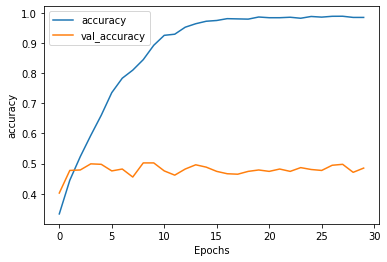

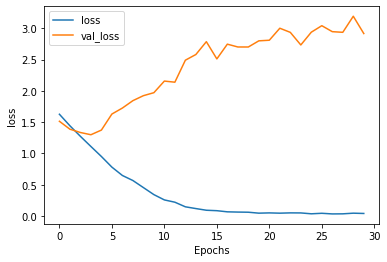

In [21]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [22]:
from sklearn.metrics import classification_report
y_pred=model.predict(test_dataset, batch_size=batch_size)
y_pred = np.argmax(y_pred,axis=1)

In [23]:
y_pred = y_pred.reshape(-1,1)

In [24]:
categories = ['sad', 'angry','surprise','happy','fear','disgust']
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

         sad       0.21      0.22      0.21       132
       angry       0.15      0.09      0.12        64
    surprise       0.04      0.06      0.05        36
       happy       0.30      0.31      0.31       192
        fear       0.24      0.27      0.25       146
     disgust       0.08      0.06      0.07        70

    accuracy                           0.22       640
   macro avg       0.17      0.17      0.17       640
weighted avg       0.21      0.22      0.22       640



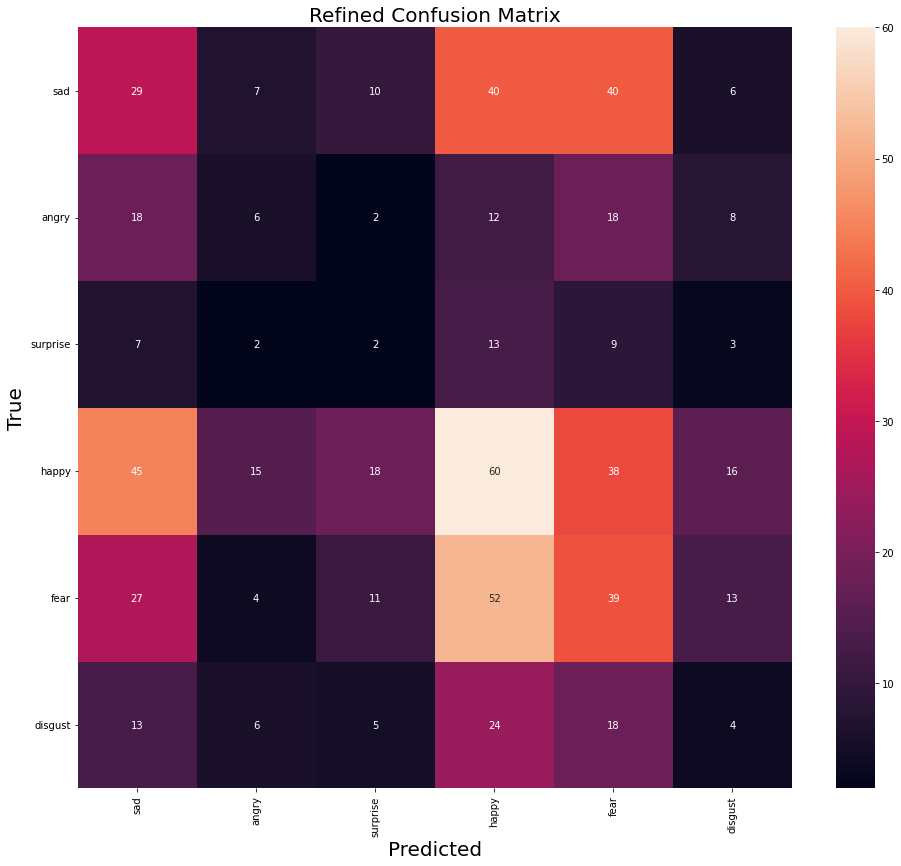

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 6
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

Influenced by:
Kaggle Notebook:https://www.kaggle.com/code/lmasca/disaster-tweets-using-bert-embeddings-and-lstm/notebook